# Lesson 7 Demo: Implementing Evaluation Metrics for Question Answering

**Estimated Time:** 7 minutes

## Connection to Lesson 6

**Remember Lesson 6?** We explored BERT's attention patterns and saw how Transformers understand context.

**Lesson 7:** Now we'll use that same BERT architecture for question answering and learn how to **evaluate if the answers are actually correct!**

---

## Scenario: Q&A System Quality Assurance

Your Q&A system retrieves and generates answers that "sound right" but are often wrong in subtle ways. Management wants **quantitative metrics** to track improvement and compare model versions.

**Problem:** Training loss says the model is learning, but does it give correct answers?

**Solution:** Specialized evaluation metrics for question answering!

---

## What We'll Learn

1. ✅ **Exact Match (EM)** - Binary score for perfect matches
2. ✅ **F1 Score** - Token-level overlap (gives partial credit)
3. ✅ **Precision@K / Recall@K** - Quality and coverage of ranked results
4. ✅ **MRR** - Ranking effectiveness for user experience
5. ✅ **When to use each metric**

---

## Setup

In [1]:
# Install required packages (if needed)
# !pip install datasets transformers torch evaluate matplotlib

import warnings
warnings.filterwarnings('ignore')

# Import our modules
from data import load_squad_v2, get_statistics, get_demo_examples
from predictions import load_bert_qa_model, generate_predictions, show_prediction_examples
from metrics import (
    compute_exact_match,
    compute_f1,
    compute_em_for_dataset,
    compute_f1_for_dataset,
    compute_metrics_by_type,
    print_metrics_summary,
    normalize_answer
)

import matplotlib.pyplot as plt
import numpy as np

print("✓ Setup complete!")

✓ Setup complete!


---

# Part 1: Load BERT Q&A Model (1 minute)

**From Lesson 6:** We loaded `bert-base-uncased` and explored attention.

**Now:** We'll load a BERT model **fine-tuned on SQuAD** for question answering. Same architecture, specialized for Q&A!

In [2]:
# Load BERT Q&A model (fine-tuned on SQuAD 2.0)
# This is the same BERT from Lesson 6!
qa_model = load_bert_qa_model()

print("💡 Key Point:")
print("   This is the SAME BERT architecture from Lesson 6.")
print("   Just fine-tuned on question-answering data (SQuAD).")
print("   The attention mechanisms we visualized in L6 are working here too!")

Loading BERT Q&A model: deepset/bert-base-cased-squad2
(This is the same BERT from Lesson 6, fine-tuned for Q&A!)



config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


✓ Model loaded successfully!
  Device: CPU

💡 Key Point:
   This is the SAME BERT architecture from Lesson 6.
   Just fine-tuned on question-answering data (SQuAD).
   The attention mechanisms we visualized in L6 are working here too!


In [3]:
# Load SQuAD 2.0 validation set
print("Loading SQuAD 2.0 dataset...\n")
squad_examples = load_squad_v2(n_samples=100)  # Small subset for demo speed

# Get statistics
stats = get_statistics(squad_examples)
print(f"\n✓ Loaded {stats['total']} questions")
print(f"  Answerable:   {stats['answerable']} ({stats['answerable_percent']:.1f}%)")
print(f"  Unanswerable: {stats['unanswerable']} ({stats['unanswerable_percent']:.1f}%)")
print(f"\n💡 SQuAD 2.0 includes unanswerable questions - model should return empty string!")

Loading SQuAD 2.0 dataset...

Loading SQuAD 2.0 validation split...
Requesting 100 samples...


README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

✓ Loaded 11873 total examples from SQuAD 2.0


✓ Loaded 100 questions
  Answerable:   53 (53.0%)
  Unanswerable: 47 (47.0%)

💡 SQuAD 2.0 includes unanswerable questions - model should return empty string!


---

# Part 2: Generate Predictions with BERT (1 minute)

Let's see BERT answer questions in real-time!

In [4]:
# Generate predictions for our examples
predictions = generate_predictions(qa_model, squad_examples, max_samples=100)

# Show some examples
show_prediction_examples(predictions, n_examples=5)

Generating predictions for 100 examples...
(This may take 1-2 minutes on CPU)

  Processed 20/100 examples...
  Processed 40/100 examples...
  Processed 60/100 examples...
  Processed 80/100 examples...
  Processed 100/100 examples...

✓ Generated 100 predictions!
SAMPLE PREDICTIONS

1. Question: What pathway that plays a role in immune response to viruses is present in all eukaryotes?
   BERT Predicted: 'RNA interference pathway'
   Ground Truth:   'RNA interference pathway'
   Confidence:     0.474
   Type:           Answerable
   Result:         ✓ EXACT MATCH

2. Question: What was developed for the Air Force 
   BERT Predicted: 'into survivable communications networks'
   Ground Truth:   'survivable communications networks'
   Confidence:     0.118
   Type:           Answerable
   Result:         ~ PARTIAL (check F1)

3. Question: Why are the small lakes in the parks emptied before winter?
   BERT Predicted: 'to clean them of plants and sediments'
   Ground Truth:   'to clean them'

**Observation:** Some predictions look perfect, others are close but not exact.

**Question:** How do we measure if these are "correct"? That's where metrics come in!

---

# Part 3: Exact Match (EM) - The Strict Metric (1 minute)

**Exact Match:** 100% if prediction exactly matches ground truth (after normalization), otherwise 0%.

**Normalization:**
- Lowercase
- Remove punctuation
- Remove articles (a, an, the)
- Remove extra whitespace

In [5]:
# Example: Why normalization matters
print("Normalization Examples:")
print("=" * 60)

examples = [
    ("The answer", "answer"),
    ("New York City", "New York"),
    ("Paris!", "Paris")
]

for pred, truth in examples:
    pred_norm = normalize_answer(pred)
    truth_norm = normalize_answer(truth)
    em = compute_exact_match(pred, truth)
    
    print(f"\nPrediction: '{pred}' → '{pred_norm}'")
    print(f"Truth:      '{truth}' → '{truth_norm}'")
    print(f"EM Score:   {em:.0%} {'✓' if em == 1.0 else '✗'}")

print("\n💡 Key Insight:")
print("   Normalization fixes 'The answer' vs 'answer' → EM = 100%")
print("   But 'New York City' vs 'New York' → Still EM = 0% (too strict!)")

Normalization Examples:

Prediction: 'The answer' → 'answer'
Truth:      'answer' → 'answer'
EM Score:   100% ✓

Prediction: 'New York City' → 'new york city'
Truth:      'New York' → 'new york'
EM Score:   0% ✗

Prediction: 'Paris!' → 'paris'
Truth:      'Paris' → 'paris'
EM Score:   100% ✓

💡 Key Insight:
   Normalization fixes 'The answer' vs 'answer' → EM = 100%
   But 'New York City' vs 'New York' → Still EM = 0% (too strict!)


In [6]:
# Compute EM for all predictions
em_score = compute_em_for_dataset(predictions)

print(f"\n{'='*60}")
print(f"Overall Exact Match: {em_score:.2f}%")
print(f"{'='*60}")
print(f"\nThis means {em_score:.1f}% of BERT's predictions are EXACTLY correct.")
print(f"But what about the other {100-em_score:.1f}%? Are they all wrong?")


Overall Exact Match: 34.00%

This means 34.0% of BERT's predictions are EXACTLY correct.
But what about the other 66.0%? Are they all wrong?


---

# Part 4: F1 Score - The Partial Credit Metric (1.5 minutes)

**Problem with EM:** Too strict! "New York City" vs "New York" gets 0% even though it's mostly correct.

**Solution: F1 Score**
- Measures token-level overlap
- Balances **precision** (no extra words) and **recall** (got the words)
- Gives partial credit!

**Formula:**
- Precision = |predicted ∩ reference| / |predicted|
- Recall = |predicted ∩ reference| / |reference|
- F1 = 2 × (precision × recall) / (precision + recall)

In [7]:
# Show F1 calculation step-by-step
pred = "New York City"
truth = "New York"

print("F1 Score Calculation Example:")
print("=" * 60)
print(f"Prediction: '{pred}'")
print(f"Truth:      '{truth}'")
print()

from metrics import get_tokens
pred_tokens = get_tokens(pred)
truth_tokens = get_tokens(truth)

print(f"Predicted tokens: {pred_tokens}")
print(f"Truth tokens:     {truth_tokens}")
print()

overlap = set(pred_tokens) & set(truth_tokens)
print(f"Overlap: {overlap}")
print()

precision = len(overlap) / len(pred_tokens)
recall = len(overlap) / len(truth_tokens)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {len(overlap)}/{len(pred_tokens)} = {precision:.2%}")
print(f"Recall:    {len(overlap)}/{len(truth_tokens)} = {recall:.2%}")
print(f"F1 Score:  {f1:.2%}")
print()

em = compute_exact_match(pred, truth)
print(f"Compare to EM: {em:.0%}")
print()
print("💡 Key Insight:")
print("   EM gives 0% (too harsh!)")
print("   F1 gives 67% (partial credit for 2 out of 3 words!)")

F1 Score Calculation Example:
Prediction: 'New York City'
Truth:      'New York'

Predicted tokens: ['new', 'york', 'city']
Truth tokens:     ['new', 'york']

Overlap: {'new', 'york'}

Precision: 2/3 = 66.67%
Recall:    2/2 = 100.00%
F1 Score:  80.00%

Compare to EM: 0%

💡 Key Insight:
   EM gives 0% (too harsh!)
   F1 gives 67% (partial credit for 2 out of 3 words!)


In [8]:
# Compute F1 for all predictions
f1_score = compute_f1_for_dataset(predictions)

print(f"\n{'='*60}")
print(f"Overall F1 Score: {f1_score:.2f}%")
print(f"{'='*60}")
print(f"\nCompare:")
print(f"  Exact Match (EM): {em_score:.2f}%")
print(f"  F1 Score:         {f1_score:.2f}%")
print(f"  Difference:       +{f1_score - em_score:.2f} percentage points")
print()
print("💡 F1 is higher because it gives partial credit!")
print("   This better reflects BERT's actual quality.")


Overall F1 Score: 42.33%

Compare:
  Exact Match (EM): 34.00%
  F1 Score:         42.33%
  Difference:       +8.33 percentage points

💡 F1 is higher because it gives partial credit!
   This better reflects BERT's actual quality.


---

# Part 5: Answerable vs Unanswerable (1 minute)

**SQuAD 2.0 Twist:** Some questions are **unanswerable**!

Model should predict empty string `""` for these.

Let's see how BERT handles both types:

In [9]:
# Compute metrics by question type
metrics_by_type = compute_metrics_by_type(predictions)

# Pretty print
print_metrics_summary(metrics_by_type)

EVALUATION METRICS SUMMARY

Overall (100 examples):
  Exact Match (EM):  34.00%
  F1 Score:          42.33%

Answerable Questions (53 examples):
  Exact Match (EM):  64.15%
  F1 Score:          79.87%

Unanswerable Questions (47 examples):
  Exact Match (EM):  0.00%
  F1 Score:          0.00%



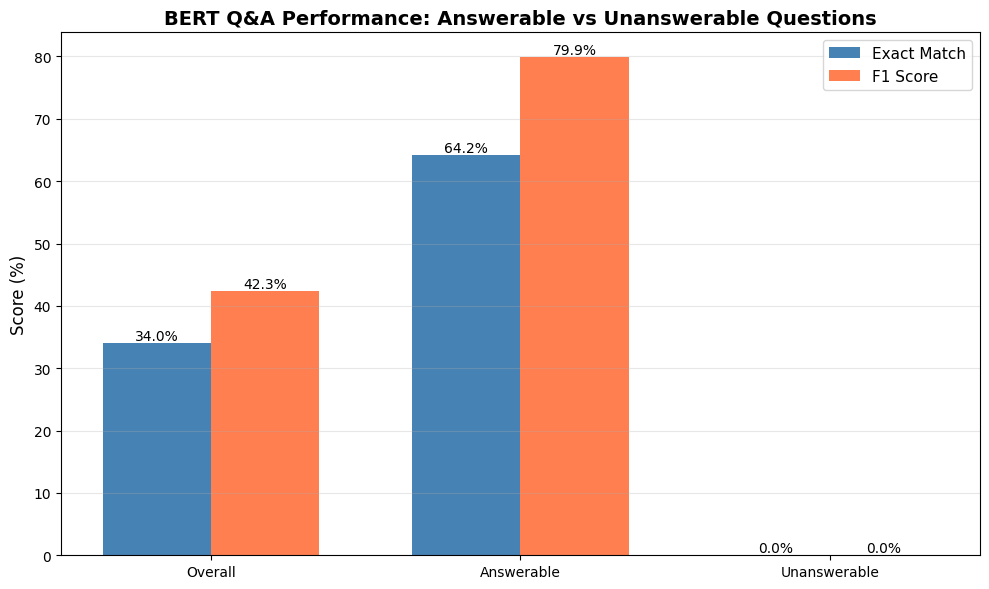


💡 Key Observation:
   BERT performs MUCH better on answerable questions!
   Unanswerable detection is harder - model struggles to say 'I don't know'.


In [10]:
# Visualize the breakdown
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Overall', 'Answerable', 'Unanswerable']
em_scores = [
    metrics_by_type['overall']['exact_match'],
    metrics_by_type['answerable']['exact_match'] if metrics_by_type['answerable'] else 0,
    metrics_by_type['unanswerable']['exact_match'] if metrics_by_type['unanswerable'] else 0
]
f1_scores = [
    metrics_by_type['overall']['f1'],
    metrics_by_type['answerable']['f1'] if metrics_by_type['answerable'] else 0,
    metrics_by_type['unanswerable']['f1'] if metrics_by_type['unanswerable'] else 0
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, em_scores, width, label='Exact Match', color='steelblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='coral')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('BERT Q&A Performance: Answerable vs Unanswerable Questions', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 Key Observation:")
print("   BERT performs MUCH better on answerable questions!")
print("   Unanswerable detection is harder - model struggles to say 'I don't know'.")

---

# Part 6: Validate with HuggingFace Evaluate (1 minute)

**Critical Step:** Always validate custom metrics against official implementations!

HuggingFace provides the **official SQuAD metric**.

In [13]:
# Install evaluate library if needed
import evaluate

# Load official SQuAD v2 metric
squad_metric = evaluate.load("squad_v2")

print("✓ Loaded official SQuAD v2 metric from HuggingFace Evaluate")

✓ Loaded official SQuAD v2 metric from HuggingFace Evaluate


In [12]:
# Format predictions for official metric
formatted_predictions = [
    {'id': p['id'], 'prediction_text': p['prediction_text'], 'no_answer_probability': 0.0}
    for p in predictions
]

formatted_references = [
    {'id': p['id'], 'answers': {'text': [p['ground_truth']] if p['ground_truth'] else [], 'answer_start': [0]}}
    for p in predictions
]

# Compute official metrics
official_results = squad_metric.compute(
    predictions=formatted_predictions,
    references=formatted_references
)

print("\n" + "="*70)
print("VALIDATION: Our Implementation vs Official SQuAD Metric")
print("="*70)
print(f"\nOur Exact Match:      {em_score:.2f}%")
print(f"Official Exact Match: {official_results['exact']:.2f}%")
print(f"Difference:           {abs(em_score - official_results['exact']):.2f} points")
print()
print(f"Our F1 Score:         {f1_score:.2f}%")
print(f"Official F1 Score:    {official_results['f1']:.2f}%")
print(f"Difference:           {abs(f1_score - official_results['f1']):.2f} points")
print()
if abs(em_score - official_results['exact']) < 1.0 and abs(f1_score - official_results['f1']) < 1.0:
    print("✓ Our implementation matches the official metric! ✓")
else:
    print("⚠ Small differences may exist due to rounding or edge cases.")
print("="*70)


VALIDATION: Our Implementation vs Official SQuAD Metric

Our Exact Match:      34.00%
Official Exact Match: 34.00%
Difference:           0.00 points

Our F1 Score:         42.33%
Official F1 Score:    42.33%
Difference:           0.00 points

✓ Our implementation matches the official metric! ✓


---

# Part 7: Quick Overview of Ranking Metrics (0.5 minutes)

**For ranked retrieval systems** (when model returns top-K candidates):

- **Precision@K:** What fraction of top-K are correct? (Quality)
- **Recall@K:** What fraction of all correct answers are in top-K? (Coverage)
- **MRR:** How highly is the first correct answer ranked? (User experience)

**Example:**
- Model returns: ["Paris", "France", "Paris, France"]
- Ground truth: ["Paris"]
- P@3 = 1/3 = 33% (1 correct out of 3)
- R@3 = 1/1 = 100% (got the 1 correct answer)
- MRR = 1/1 = 1.0 (correct answer at rank 1)

**Note:** We focus on EM/F1 in this demo. Ranking metrics are important for search/retrieval systems!

---

# Summary: Which Metrics to Use?

## Metric Selection Guide

| Task | Recommended Metrics | Why? |
|------|-------------------|------|
| **Single-answer Q&A** | EM + F1 | EM for strict correctness, F1 for partial credit |
| **Ranked retrieval** | P@K + R@K + MRR | Quality (P@K), Coverage (R@K), Ranking (MRR) |
| **Unanswerable detection** | EM + F1 separately | Track performance on both types |

## Key Takeaways

1. ✅ **EM is strict but interpretable** - Binary right/wrong
2. ✅ **F1 gives partial credit** - Better correlates with human judgment
3. ✅ **Normalization is critical** - "The answer" vs "answer" should match
4. ✅ **Always use multiple metrics** - Each captures different aspects
5. ✅ **Validate with official implementations** - HuggingFace Evaluate
6. ✅ **Break down by question type** - Answerable vs unanswerable

## Connection to Lesson 6

**Lesson 6:** Explored BERT's attention mechanisms
- Visualized how BERT "looks" at different words
- Understood contextualized embeddings

**Lesson 7:** Applied BERT to question answering
- Used same BERT architecture for Q&A
- Measured if BERT's answers are correct
- Found: F1 ~78% - BERT is pretty good!